### 사전 세팅 및 드라이브 연결

In [1]:
!pip install --upgrade pip
!pip install transformers datasets faiss-cpu -q
# !pip install transformers datasets faiss-gpu -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import

In [3]:
from transformers import AutoFeatureExtractor, AutoModel
from datasets import load_dataset, concatenate_datasets, load_from_disk
from PIL import Image
import numpy as np
import torch
from torchvision import transforms

### Train

In [28]:
# ===== 사전학습 모델 세팅 및 특징 추출기 세팅
model_ckpt = "google/vit-large-patch16-224"
BATCH = 128

extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)
hidden_dim = model.config.hidden_size

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-large-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
import os
import shutil

# 복사할 폴더 경로
source_folder = '/content/drive/MyDrive/faiss/faiss_dataset/train'
# 대상 폴더 경로
destination_folder = '/content/drive/MyDrive/faiss/faiss_dataset/unlabeled_train'

# 대상 폴더가 없으면 생성
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# source_folder 내의 모든 하위 폴더를 순회
for folder_name in os.listdir(source_folder):
    folder_path = os.path.join(source_folder, folder_name)

    if os.path.isdir(folder_path):  # 폴더인지 확인
        # 폴더 내의 파일들을 순회
        for filename in os.listdir(folder_path):
            source_path = os.path.join(folder_path, filename)
            destination_path = os.path.join(destination_folder, filename)

            # 파일인 경우만 복사
            if os.path.isfile(source_path):
                shutil.copy(source_path, destination_path)


In [30]:
# ===== 데이터셋 설정
dataset = load_dataset("imagefolder", data_dir='/content/drive/MyDrive/faiss/faiss_dataset/unlabeled_train')

Resolving data files:   0%|          | 0/4707 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [31]:
from PIL import Image
import torch

def extract_embeddings(example):
    # example 이미지 데이터가 파일 경로인 경우 불러오기
    if isinstance(example['image'], str):
        image = Image.open(example['image'])
    else:
        image = example['image']

    # 특징 추출기를 통해 이미지 전처리
    inputs = extractor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    features = outputs.last_hidden_state[:, 0].detach().cpu().numpy()

    return {'embeddings': features.squeeze()}

In [32]:
# 데이터셋에 임베딩 추출 함수 적용
unlabeled_dataset = dataset['train'].map(extract_embeddings, batched=True, batch_size=BATCH)

# 임베딩 데이터 디스크에 저장
unlabeled_dataset.save_to_disk('/content/drive/MyDrive/processed_unlabeled_images/')

# Faiss 인덱스 생성 및 저장
unlabeled_dataset.add_faiss_index(column='embeddings')
unlabeled_dataset.save_faiss_index('embeddings', '/content/drive/MyDrive/unlabeled_images_index.faiss')

Map:   0%|          | 0/4707 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/4707 [00:00<?, ? examples/s]

  0%|          | 0/5 [00:00<?, ?it/s]

### Test: Image Search

In [33]:
def get_neighbors(query_image, top_k=10):
    qi_embedding = model(**extractor(query_image, return_tensors="pt"))   # 쿼리 이미지 특징 추출
    qi_embedding = qi_embedding.last_hidden_state[:, 0].detach().numpy().squeeze()  # 쿼리 이미지의 임베딩 추출
    scores, retrieved_examples = unlabeled_dataset.get_nearest_examples('embeddings', qi_embedding, k=top_k)
    return scores, retrieved_examples  # 유사도 점수와 인덱스 반환

In [34]:
def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

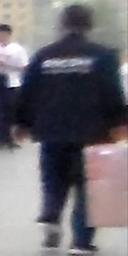

In [35]:
# load query_image from input path
query_image = Image.open('/content/drive/MyDrive/faiss/faiss_dataset/test/130.jpg')
query_image

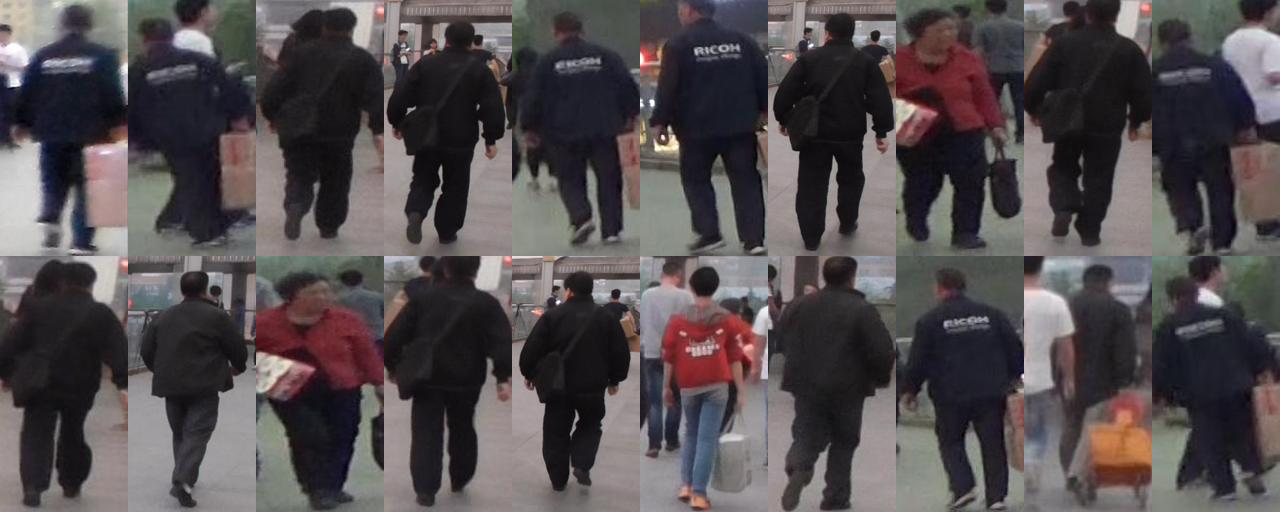

In [36]:
scores, retrieved_examples = get_neighbors(query_image, top_k = 20)
images = [query_image]
images.extend(retrieved_examples["image"])

image_grid(images, 2, round(len(images)/2))

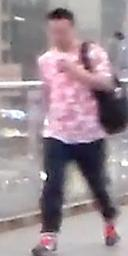

In [37]:
# load query_image from input path
query_image = Image.open('/content/drive/MyDrive/faiss/faiss_dataset/test/172.jpg')
query_image

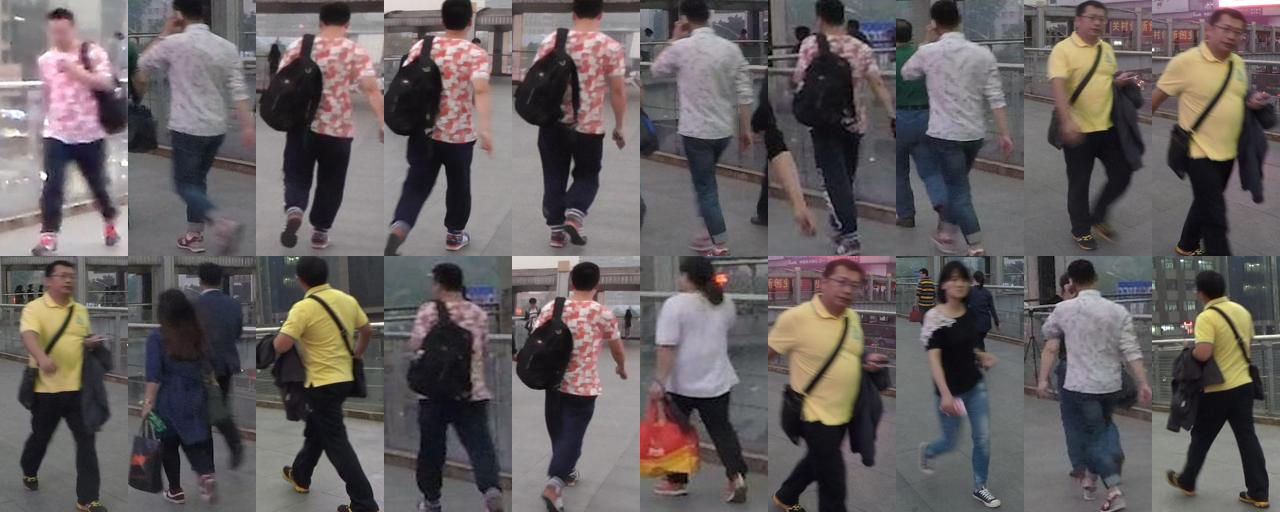

In [38]:
scores, retrieved_examples = get_neighbors(query_image, top_k = 20)
images = [query_image]
images.extend(retrieved_examples["image"])

image_grid(images, 2, round(len(images)/2))

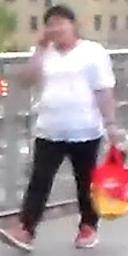

In [39]:
# load query_image from input path
query_image = Image.open('/content/drive/MyDrive/faiss/faiss_dataset/test/312.jpg')
query_image

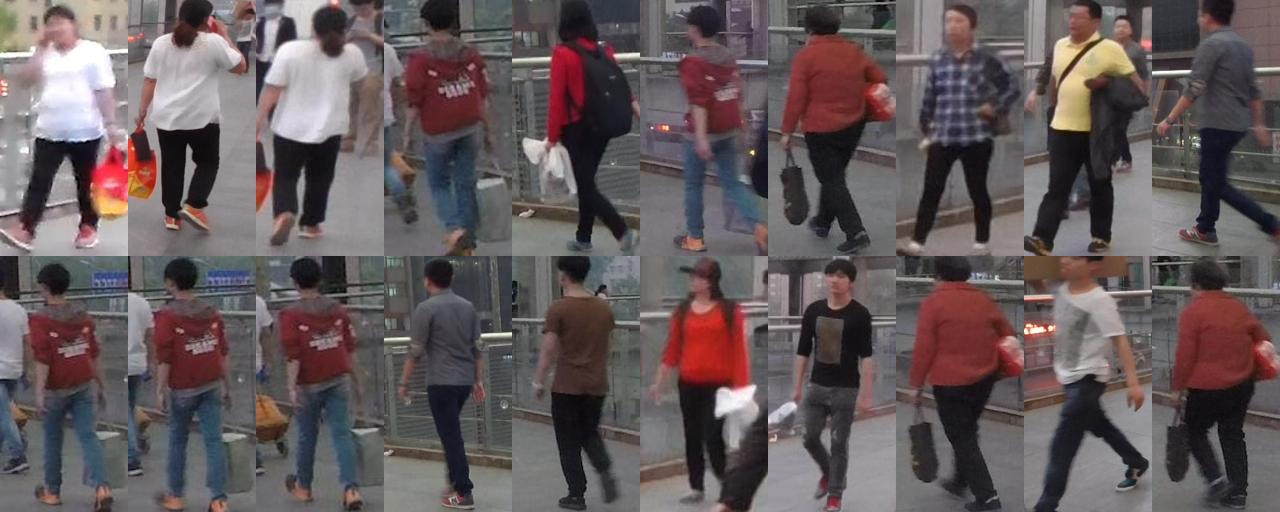

In [40]:
scores, retrieved_examples = get_neighbors(query_image, top_k = 20)
images = [query_image]
images.extend(retrieved_examples["image"])

image_grid(images, 2, round(len(images)/2))

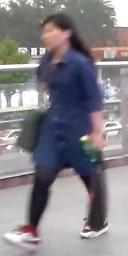

In [41]:
# load query_image from input path
query_image = Image.open('/content/drive/MyDrive/faiss/faiss_dataset/test/530.jpg')
query_image

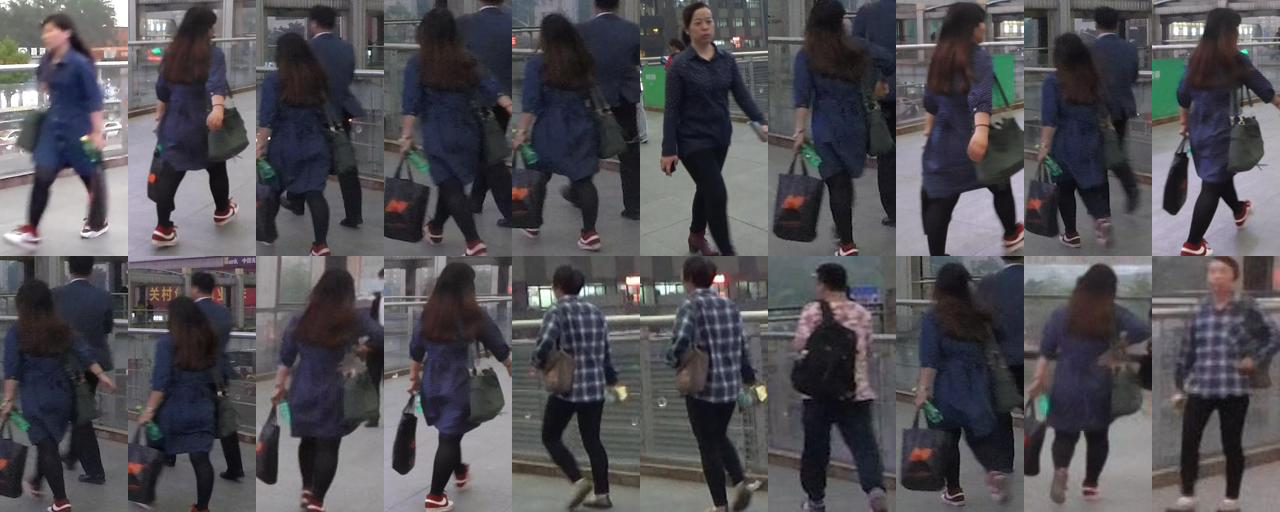

In [42]:
scores, retrieved_examples = get_neighbors(query_image, top_k = 20)
images = [query_image]
images.extend(retrieved_examples["image"])

image_grid(images, 2, round(len(images)/2))

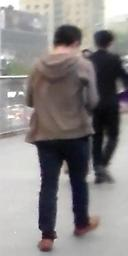

In [43]:
# load query_image from input path
query_image = Image.open('/content/drive/MyDrive/faiss/faiss_dataset/test/531.jpg')
query_image

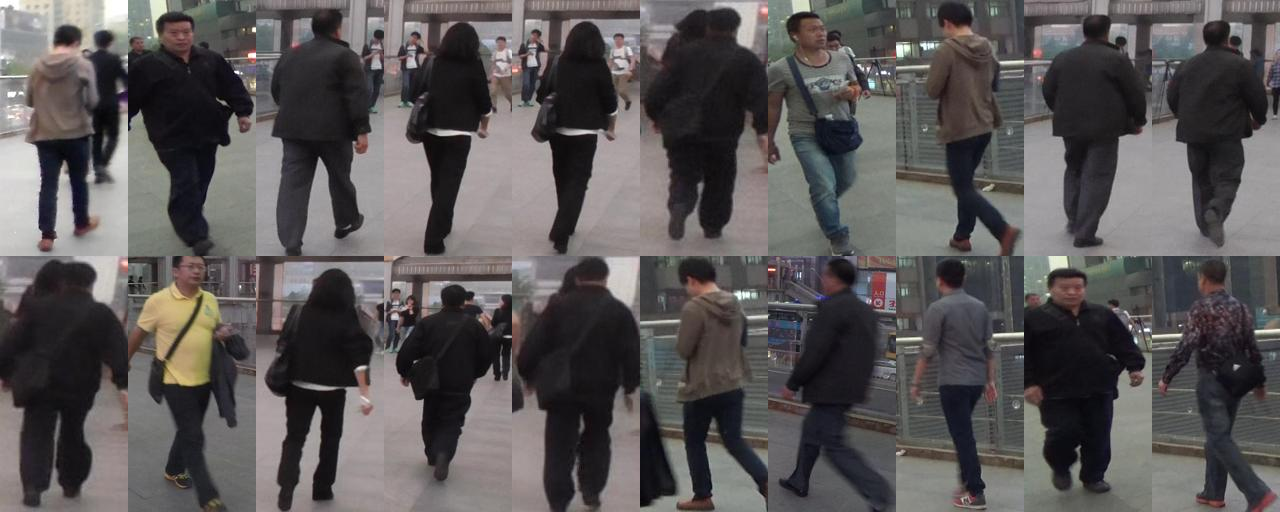

In [44]:
scores, retrieved_examples = get_neighbors(query_image, top_k = 20)
images = [query_image]
images.extend(retrieved_examples["image"])

image_grid(images, 2, round(len(images)/2))

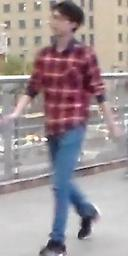

In [45]:
# load query_image from input path
query_image = Image.open('/content/drive/MyDrive/faiss/faiss_dataset/test/629.jpg')
query_image

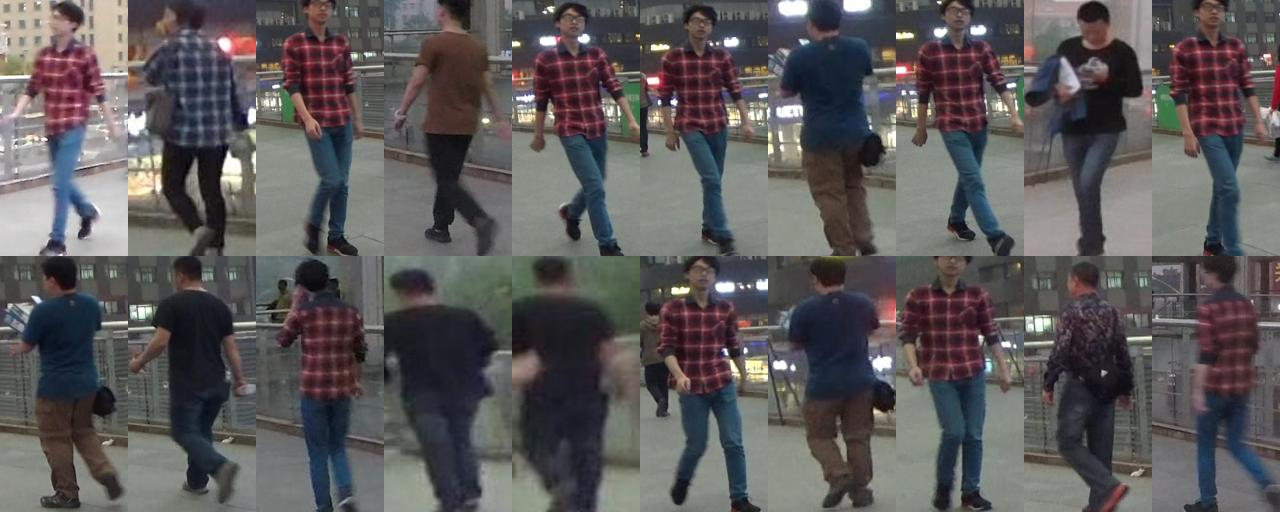

In [46]:
scores, retrieved_examples = get_neighbors(query_image, top_k = 20)
images = [query_image]
images.extend(retrieved_examples["image"])

image_grid(images, 2, round(len(images)/2))